Import Modules

In [55]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline

Load Dataset

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /d1; to attempt to forcibly remount, call drive.mount("/d1", force_remount=True).


In [57]:
import os

BASE_DIR = '/content'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_name = os.path.splitext(image)[0]  # Get the image name without the extension
    img_components = image_name.split('_')
    
    if len(img_components) < 2:
        continue  # Skip files that don't match the expected naming convention
    
    try:
        age_label = int(img_components[0])
        gender_label = int(img_components[1])
    except ValueError:
        continue  # Skip files that cannot be converted to integers
    
    image_path = os.path.join(BASE_DIR, image)
    
    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)


  0%|          | 0/39 [00:00<?, ?it/s]

In [58]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 35, Number of gender_labels: 35, Number of image_paths: 35


In [59]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [60]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/26_1_3_20170119155639573.jpg.chip.jpg,26,1
1,/content/100_0_0_20170112213500903.jpg.chip.jpg,100,0
2,/content/105_1_0_20170112213001988.jpg.chip.jpg,105,1
3,/content/9_1_0_20170109204754719.jpg.chip.jpg,9,1
4,/content/9_1_1_20170117105556810.jpg.chip.jpg,9,1


EDA(Exploratory Data Analysis)

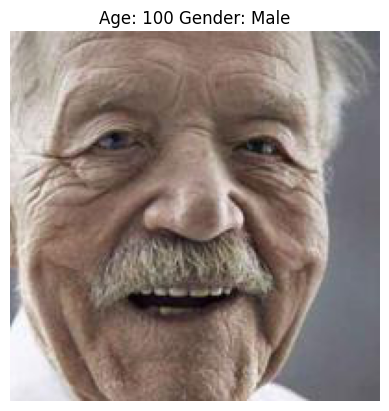

In [61]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

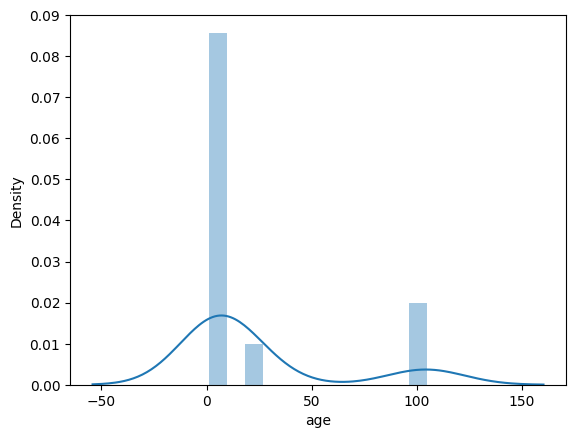

In [62]:
 # Age distribution
 sns.distplot(df['age'])

<Axes: ylabel='count'>

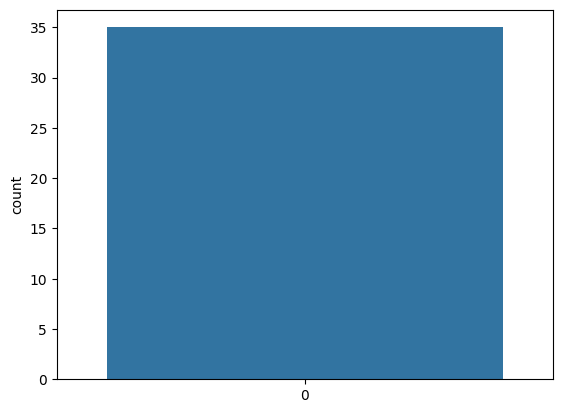

In [63]:
sns.countplot(df['gender'])

In [64]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

Feature Extration

In [65]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [66]:
X = extract_image_features(df['image_path'])

  0%|          | 0/35 [00:00<?, ?it/s]

In [67]:
X.shape

(35, 128, 128, 1)

In [68]:
X = X / 255.0

In [69]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [70]:
input_shape = (128, 128, 1)

In [71]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

Plot Model

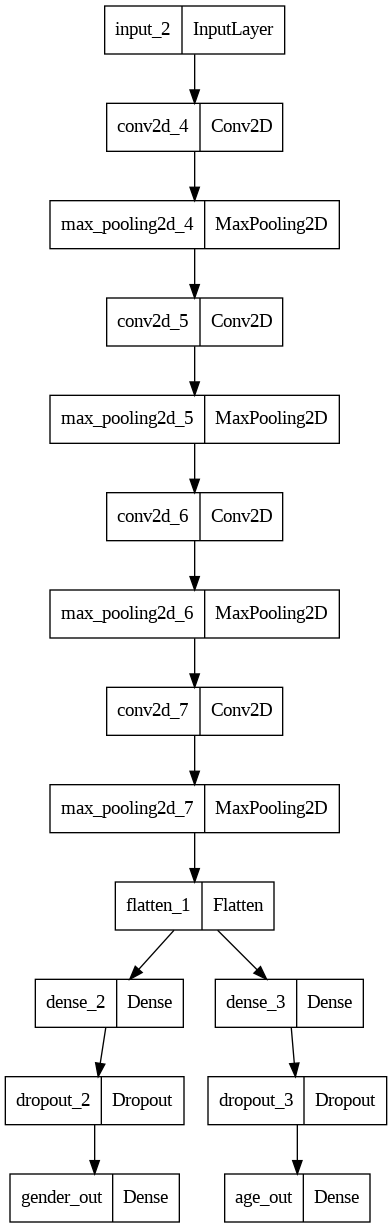

In [72]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [73]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 21.9381 - gender_out_loss: 0.6913 - age_out_loss: 21.2468 - gender_out_accuracy: 0.5714 - age_out_accuracy: 0.0000e+00 - val_loss: 35.9889 - val_gender_out_loss: 0.3218 - val_age_out_loss: 35.6672 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.2857
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 20.6728 - gender_out_loss: 0.3800 - age_out_loss: 20.2928 - gender_out_accuracy: 0.9286 - age_out_accuracy: 0.1786 - val_loss: 34.5986 - val_gender_out_loss: 0.0243 - val_age_out_loss: 34.5743 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 19.0408 - gender_out_loss: 0.2884 - age_out_loss: 18.7524 - gender_out_accuracy: 0.9286 - age_out_accuracy: 0.1786 - val_loss: 33.9121 - val_gender_out_loss: 2.6599e-04 - val_age_out_loss: 33.9118 - val_gender_out_accuracy: 1.0000 - val_age_out_accuracy: 0.2857
Epoch 4/50


Plot Results

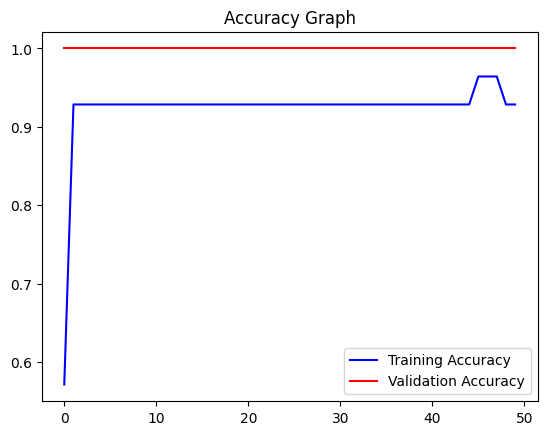

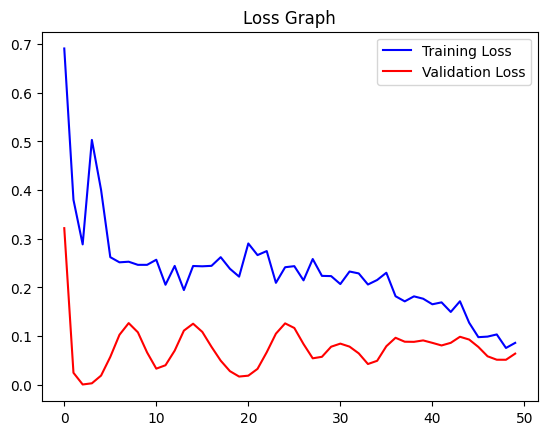

In [74]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

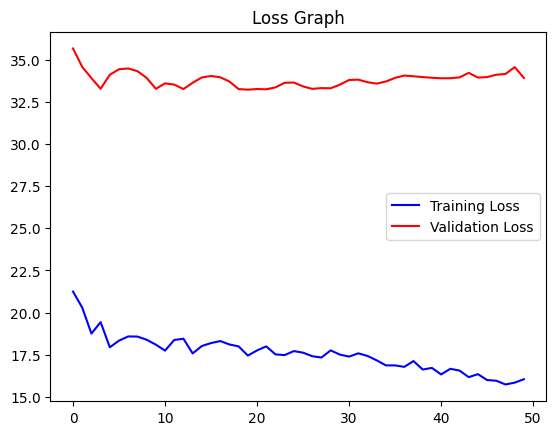

In [75]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Predicting Test Data

In [76]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 223ms/step


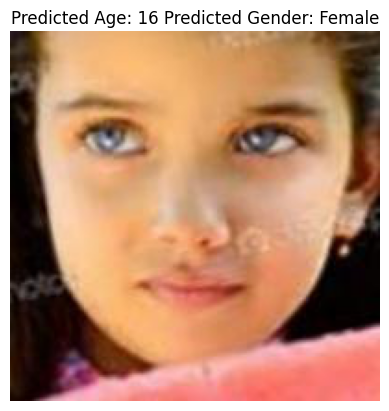

In [79]:
img_to_test = '/d1/MyDrive/d1/8_1_4_20170104005426863.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))